In [1]:
import random
import sys
sys.path.append('/home/elgutto/Documents/masters/atari/atari/lib/python3.8/site-packages')
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm
from copy import deepcopy
import datetime
from pathlib import Path
import time
from datetime import timedelta
import json
from collections import namedtuple
import cv2

In [2]:
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def act(self):
        return random.choice(self.action_space)

# From https://github.com/uber-research/go-explore/blob/240056852514ffc39f62d32ae7590a39fd1814b9/policy_based/goexplore_py/explorers.py#L26
# Repeats actions with 95% probability
# TODO: is it equivalent to sticky actions?
class ActionRepetitionAgent:
    def __init__(self, action_space, mean_repeat=20):
        self.action_space = action_space
        self.mean_repeat = mean_repeat
        self.action = 0 # noop
        self.remaining = 0
        
    def act(self):
        if self.remaining <= 0:
            self.remaining = np.random.geometric(1 / self.mean_repeat)
            self.action = random.choice(self.action_space)
        self.remaining -= 1
        return self.action
            

In [3]:
# https://gist.github.com/mttk/74dc6eaaea83b9f06c2cc99584d45f96
# Larger rendering video
from gym.envs.classic_control import rendering
def repeat_upsample(rgb_array, k=1, l=1, err=[]):
    # repeat kinda crashes if k/l are zero
    if k <= 0 or l <= 0: 
        if not err: 
            err.append('logged')
        return rgb_array

    # repeat the pixels k times along the y axis and l times along the x axis
    # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

    return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

viewer = rendering.SimpleImageViewer()

In [4]:
class Cell:
    def __init__(self, simulator_state, actions_taken, score):
        self.visits = 0
        self.done = False
        self.update(simulator_state, actions_taken, score)
        
    def update(self, simulator_state, actions_taken, score):
        self.simulator_state = simulator_state
        self.actions_taken = actions_taken
        self.score = score
    
    def increment_visits(self):
        self.visits += 1
        
    def restore_state(self, env):
        env.unwrapped.restore_state(self.simulator_state)
        
    def history(self):
        return deepcopy(self.actions_taken), deepcopy(self.score)
    
    def is_worse(self, score, actions_taken_length):
        return ((score > self.score) 
                or (score == self.score and actions_taken_length < len(self.actions_taken)))
    
    def set_done(self):
        self.done = True
    
    def __repr__(self):
        return f'Cell(score={self.score}, traj_len={len(self.actions_taken)}, visits={self.visits}, done={self.done})'
    
    # Make sortable
    def __eq__(self, other):
        return self.score == other.score and self.lenght == other.length
    
    def __lt__(self, other):
        return (-self.score, len(self.actions_taken)) < (-other.score, len(other.actions_taken))
    
def cell_repr(img):
    # Crop and resize
    img = img[34:194:2, ::2]
    #img = img[34:194, :]

    # Convert to greyscale
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.mean(axis=2)

    # Shrink
    # https://github.com/uber-research/go-explore/blob/240056852514ffc39f62d32ae7590a39fd1814b9/robustified/goexplore_py/utils.py#L67
    #img = cv2.resize(img, (14, 14), interpolation=cv2.INTER_AREA)
    img = ndimage.interpolation.zoom(img, 0.1)
    
    # Binarize
    img = np.round(img, 2)
    threshold = 77.7
    img[img < threshold] = 0
    img[img >= threshold] = 1
    
    # Reduce pixel depth
    #img = color_quantize(img, 10)

    return tuple(img.flatten())

def color_quantize(img, n_colors):
    bits = np.log2(n_colors)
    diff = 8 - bits # Assumes 2^8 = 256 original pixel depth
    K = 2**diff
    
    img = K * (img // K)
    return img

In [5]:
def explore(env, agent, archive, cell, stickyness, maxsteps, n_iterations, n_frames, highscore, visualize=False):
    state = env.reset()
    cell.restore_state(env)
    actions_taken, score = cell.history()
    
    done = False
    n_steps = 0
    seen_cells = set() # Track cells seen during the episode
    
    action = agent.act()
    while (not done and n_steps < maxsteps):
        # Interact
        if random.random() > stickyness:
            action = agent.act()
        
        state, reward, done, _ = env.step(action)
        actions_taken.append(action)
        
        score += reward
        if score > highscore:
            highscore = score
            print(f'New highscore: {highscore}')
        
        # Update or add cell to archive
        cell_representation = cell_repr(state)
        cell = _update_or_create_cell(archive, cell_representation, env, score, deepcopy(actions_taken))
        
        # Increment visit count if cell not seen during the episode
        if cell_representation not in seen_cells:
            seen_cells.add(cell_representation)
            cell.increment_visits()
        
        n_steps += 1
        n_frames += 1
        if done: 
            cell.set_done()
            break
    
    n_iterations += 1
    return highscore, n_frames, n_iterations

def _update_or_create_cell(archive, cell_representation, env, score, actions_taken):
    if cell_representation in archive:
        cell = archive[cell_representation]
        if cell.is_worse(score, len(actions_taken)):
            simulator_state = env.unwrapped.clone_state(include_rng=True)
            cell.update(simulator_state, actions_taken, score)
    else:
        simulator_state = env.unwrapped.clone_state(include_rng=True)
        cell = Cell(simulator_state, actions_taken, score)
        archive[cell_representation] = cell
    return cell

In [6]:
Experience = namedtuple('Experience', 'state action reward done')

from knockknock import email_sender
@email_sender(recipient_emails=['goexploremsc@gmail.com'])
def run_experiment(agent, params, below_threshold, path):
    stickyness, max_steps, seed, *comment = params.values()
    
    start = time.time()
    np.random.seed(seed)
    random.seed(seed)
    env = gym.make('PongDeterministic-v4')
    env.seed(seed)
    env.action_space.seed(seed)
    
    #action_space = [0, 2, 3] # noop, up, down
    #agent = RandomAgent(action_space)

    # Initialize state
    start_state = env.reset()

    # Create initial cell
    simulator_state = env.unwrapped.clone_state(include_rng=True)
    actions_taken = []
    score = 0.0
    cell = Cell(simulator_state, actions_taken, score)
    cell.increment_visits()

    # Create archive and add initial cell
    archive = {}
    cell_representation = cell_repr(start_state)
    archive[cell_representation] = cell

    # Explore until step threshold reached
    highscore, n_frames, n_iterations = 0, 0, 0
    logs = {}
    scores = []
    n_cells = []
    for _ in tqdm(while_generator(below_threshold(n_frames))):
        if not below_threshold(n_frames):
            break
        
        visits = [cell.visits for cell in archive.values()]
        #weights = [1 / np.log(c.visits + 1) for c in archive.values()]
        #probs = [w / sum(weights) for w in weights]
        rev_counts = [max(visits) + 1 - v for v in visits]
        probs = [v / sum(rev_counts) for v in rev_counts]
        cell = np.random.choice(list(archive.values()), 1, p=probs)[0]
        
        highscore, n_frames, n_iterations = explore(env, agent, archive, cell, stickyness, max_steps, n_iterations, n_frames, highscore)
        
        scores.append(highscore)
        n_cells.append(len(archive))
        
        if n_frames % 500000 == 0:
            print(f'Iterations: {n_iterations}\tFrames: {n_frames}\tScore: {highscore}\t Cells: {len(archive)}')
            
    # Extract cell that reached terminal state with highest score and smallest trajectory
    cells = list(archive.values())
    solved_cells = [cell for cell in cells if cell.done is True]
    best_cell = sorted(solved_cells)[0] if solved_cells else sorted(cells)[0]
    
    # Save logs to json file
    elapsed = (time.time() - start)
    logs['time'] = str(timedelta(seconds=elapsed))
    logs['n_frames'] = n_frames
    logs['n_iterations'] = n_iterations
    logs['highscore'] = highscore
    logs['actions_taken'] = best_cell.actions_taken
    logs['scores'] = scores
    logs['n_cells'] = n_cells
    save(logs, path, params)
    
    print(f'Highscore: {highscore}')
    return highscore
    
# https://stackoverflow.com/questions/45808140/using-tqdm-progress-bar-in-a-while-loop
def while_generator(condition):
    while condition:
        yield
        
def save(logs, path, params):
    file_name = ''
    for name, value in params.items():
        file_name += f'{name}{value}_'
    file_name += '.json'
    file_path = path / file_name
    with file_path.open('w', encoding='utf-8') as fp:
        json.dump(logs, fp, indent=4)

Error initializing plugin EntryPoint(name='libsecret', value='keyring.backends.libsecret', group='keyring.backends').
Traceback (most recent call last):
  File "/home/elgutto/anaconda3/lib/python3.8/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/elgutto/anaconda3/lib/python3.8/importlib/metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "/home/elgutto/anaconda3/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 973, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'keyring.backends.libsecret'
Error initializing plugin EntryPoint(name='macOS', value='keyring.backends.macOS', group='keyring.backends').
Traceback (most recent call 

In [7]:
def run_experiments(experiment_name, seeds, stickyness_grid, max_steps_grid, below_threshold):
    # Create folder with format {date_experimentname}
    date = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
    path = Path(f'experiments/{date}_{experiment_name}')
    path.mkdir(exist_ok=True)
    
    action_space = [0, 2, 3] # noop, up, down
    agent = ActionRepetitionAgent(action_space)
    comment = ''
    for seed in seeds:
        for stickyness in stickyness_grid:
            for max_steps in max_steps_grid:
                params = {'stickyness': stickyness, 'maxsteps': max_steps, 'seed': seed}
                run_experiment(agent, params, below_threshold, path)

In [8]:
experiment_name = 'frameskipdemos5M'
seeds = [0, 120210, 69811, 7471]

stickyness_grid = [0.0]
max_steps_grid = [100]
below_threshold = lambda x: x < 5000000

run_experiments(experiment_name, seeds, stickyness_grid, max_steps_grid, below_threshold)

364it [00:35, 10.21it/s]

New highscore: 1.0


772it [01:17,  9.45it/s]

New highscore: 2.0


1462it [02:32,  8.96it/s]

New highscore: 3.0


3307it [06:09,  8.30it/s]

New highscore: 4.0


4650it [08:59,  7.63it/s]

New highscore: 5.0


4769it [09:14,  7.41it/s]

New highscore: 6.0


4999it [09:44,  7.70it/s]

New highscore: 7.0


5001it [09:45,  7.81it/s]

Iterations: 5000	Frames: 500000	Score: 7.0	 Cells: 1119


5893it [11:45,  7.08it/s]

New highscore: 8.0


6683it [13:34,  7.11it/s]

New highscore: 9.0


8476it [17:51,  6.48it/s]

New highscore: 10.0


9058it [19:18,  6.38it/s]

New highscore: 11.0


10001it [21:42,  6.28it/s]

Iterations: 10000	Frames: 1000000	Score: 11.0	 Cells: 1321


11041it [24:26,  6.09it/s]

New highscore: 12.0


12655it [28:45,  6.01it/s]

New highscore: 13.0


15001it [35:12,  6.04it/s]

Iterations: 15000	Frames: 1500000	Score: 13.0	 Cells: 1404


15292it [36:00,  5.72it/s]

New highscore: 14.0


18005it [43:42,  5.64it/s]

New highscore: 15.0


20001it [49:28,  6.03it/s]

Iterations: 20000	Frames: 2000000	Score: 15.0	 Cells: 1447


20022it [49:32,  5.67it/s]

New highscore: 16.0


20916it [52:11,  5.37it/s]

New highscore: 17.0


22462it [56:51,  5.41it/s]

New highscore: 18.0


23611it [1:00:23,  5.25it/s]

New highscore: 19.0


25001it [1:04:42,  5.19it/s]

Iterations: 25000	Frames: 2500000	Score: 19.0	 Cells: 1487


26132it [1:08:16,  5.12it/s]

New highscore: 20.0


29186it [1:18:05,  5.91it/s]

New highscore: 21.0


51312it [2:28:12,  5.77it/s]


Highscore: 21.0


399it [00:37, 10.39it/s]

New highscore: 1.0


1487it [02:26,  9.39it/s]

New highscore: 2.0


2419it [04:09,  8.75it/s]

New highscore: 3.0


2958it [05:11,  8.49it/s]

New highscore: 4.0


3223it [05:42,  8.36it/s]

New highscore: 5.0


4035it [07:21,  7.84it/s]

New highscore: 6.0


4556it [08:27,  8.01it/s]

New highscore: 7.0


5001it [09:24,  7.79it/s]

Iterations: 5000	Frames: 500000	Score: 7.0	 Cells: 1090


7178it [14:21,  6.90it/s]

New highscore: 8.0


8036it [16:23,  7.11it/s]

New highscore: 9.0


8451it [17:22,  6.80it/s]

New highscore: 10.0


9818it [20:44,  6.58it/s]

New highscore: 11.0


10001it [21:11,  6.74it/s]

Iterations: 10000	Frames: 1000000	Score: 11.0	 Cells: 1210


11210it [24:13,  6.38it/s]

New highscore: 12.0


12653it [27:58,  5.86it/s]

New highscore: 13.0


14007it [31:36,  6.12it/s]

New highscore: 14.0


14838it [33:53,  5.75it/s]

New highscore: 15.0


15001it [34:21,  5.73it/s]

Iterations: 15000	Frames: 1500000	Score: 15.0	 Cells: 1301


15873it [36:50,  5.51it/s]

New highscore: 16.0


16962it [40:02,  5.47it/s]

New highscore: 17.0


19109it [46:34,  5.30it/s]

New highscore: 18.0


20001it [49:19,  5.28it/s]

Iterations: 20000	Frames: 2000000	Score: 18.0	 Cells: 1409


21670it [54:35,  5.21it/s]

New highscore: 19.0


23539it [1:00:37,  5.13it/s]

New highscore: 20.0


25001it [1:05:26,  5.67it/s]

Iterations: 25000	Frames: 2500000	Score: 20.0	 Cells: 1454


25592it [1:07:24,  5.46it/s]

New highscore: 21.0


51680it [2:34:16,  5.58it/s]


Highscore: 21.0


193it [00:18, 10.48it/s]

New highscore: 1.0


445it [00:42, 10.19it/s]

New highscore: 2.0


1428it [02:25,  8.89it/s]

New highscore: 3.0


2880it [05:14,  8.11it/s]

New highscore: 4.0


3114it [05:42,  8.02it/s]

New highscore: 5.0


4007it [07:32,  7.96it/s]

New highscore: 6.0


5001it [09:38,  7.55it/s]

Iterations: 5000	Frames: 500000	Score: 6.0	 Cells: 1081


5596it [10:56,  7.23it/s]

New highscore: 7.0


6721it [13:30,  7.19it/s]

New highscore: 8.0


7123it [14:26,  7.11it/s]

New highscore: 9.0


7894it [16:17,  6.86it/s]

New highscore: 10.0


9571it [20:25,  6.59it/s]

New highscore: 11.0


10001it [21:31,  6.57it/s]

Iterations: 10000	Frames: 1000000	Score: 11.0	 Cells: 1269


11250it [24:44,  5.98it/s]

New highscore: 12.0


12435it [27:51,  6.01it/s]

New highscore: 13.0


14069it [32:14,  6.11it/s]

New highscore: 14.0


15001it [34:47,  5.91it/s]

Iterations: 15000	Frames: 1500000	Score: 14.0	 Cells: 1327


15687it [36:42,  5.90it/s]

New highscore: 15.0


18880it [45:46,  5.74it/s]

New highscore: 16.0


19823it [48:31,  5.76it/s]

New highscore: 17.0


20001it [49:02,  5.87it/s]

Iterations: 20000	Frames: 2000000	Score: 17.0	 Cells: 1381


21975it [54:54,  5.42it/s]

New highscore: 18.0


22674it [57:01,  5.49it/s]

New highscore: 19.0


23489it [59:31,  5.32it/s]

New highscore: 20.0


25001it [1:04:14,  5.11it/s]

Iterations: 25000	Frames: 2500000	Score: 20.0	 Cells: 1408


25195it [1:04:51,  5.36it/s]

New highscore: 21.0


52021it [2:28:59,  5.82it/s]


Highscore: 21.0


79it [00:07, 10.18it/s]

New highscore: 1.0


448it [00:44, 10.00it/s]

New highscore: 2.0


1785it [03:07,  8.87it/s]

New highscore: 3.0


2038it [03:36,  8.71it/s]

New highscore: 4.0


2299it [04:07,  8.37it/s]

New highscore: 5.0


2740it [05:00,  7.96it/s]

New highscore: 6.0


2906it [05:20,  7.76it/s]

New highscore: 7.0


3240it [06:02,  7.67it/s]

New highscore: 8.0


4348it [08:27,  7.21it/s]

New highscore: 9.0


4856it [09:38,  7.20it/s]

New highscore: 10.0


5001it [09:58,  6.81it/s]

Iterations: 5000	Frames: 500000	Score: 10.0	 Cells: 1129


6096it [12:36,  6.83it/s]

New highscore: 11.0


6802it [14:21,  6.63it/s]

New highscore: 12.0


7846it [16:59,  6.32it/s]

New highscore: 13.0


10001it [22:36,  6.09it/s]

Iterations: 10000	Frames: 1000000	Score: 13.0	 Cells: 1276


10251it [23:16,  6.54it/s]

New highscore: 14.0


10568it [24:06,  6.02it/s]

New highscore: 15.0


13629it [32:37,  5.52it/s]

New highscore: 16.0


14256it [34:25,  5.61it/s]

New highscore: 17.0


15001it [36:35,  5.55it/s]

Iterations: 15000	Frames: 1500000	Score: 17.0	 Cells: 1372


19890it [51:11,  5.09it/s]

New highscore: 18.0


20001it [51:32,  5.31it/s]

Iterations: 20000	Frames: 2000000	Score: 18.0	 Cells: 1432


20907it [54:20,  5.20it/s]

New highscore: 19.0


21973it [57:39,  5.39it/s]

New highscore: 20.0


22442it [59:07,  5.89it/s]

New highscore: 21.0


52208it [2:32:54,  5.69it/s]


Highscore: 21.0


In [11]:
def read_actions(json_file):
    with open(json_file) as f:
        d = json.load(f)
        return d['actions_taken']
    
def demo_from_actions(actions, env):
    env.reset()
    done = False
    demonstration = []
    for action in actions:
        state, reward, done, _ = env.step(action)
        demonstration.append(Experience(state, action, reward, done))
        if done: break
    env.close()
    return demonstration

def replay(actions_taken, env):
    env.reset()
    done = False
    for action in actions_taken:
        _, _, done, _ = env.step(action)
        
        rgb = env.render('rgb_array')
        img = repeat_upsample(rgb, 8, 8)
        viewer.imshow(img)
        
        if done: break
        
    env.close()

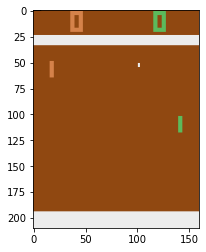

In [22]:
env = gym.make('PongDeterministic-v4')
state = env.reset()
for _ in range(200):
    action = env.action_space.sample()
    state, _, _, _ = env.step(action)
plt.imshow(state)

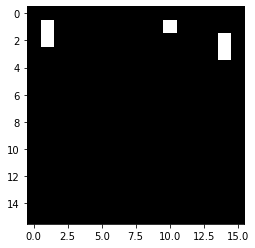

In [21]:
def downscale(img):
    # Crop and resize
    img = img[34:194, :]

    # Convert to greyscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Shrink
    # https://github.com/uber-research/go-explore/blob/240056852514ffc39f62d32ae7590a39fd1814b9/robustified/goexplore_py/utils.py#L67
    img = cv2.resize(img, (16, 16), interpolation=cv2.INTER_AREA)
    
    # Binarize
    #img = np.round(img, 2)
    #threshold = 77.7
    #img[img < threshold] = 0
    #img[img >= threshold] = 1
    
    # Reduce pixel depth
    img = color_quantize(img, 8)

    return img

cell_repr = downscale(state)
plt.imshow(cell_repr, cmap='gray')

In [26]:
cell_repr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
p = Path('experiments/2021-12-06-20:40:15_frameskipdemos5M').glob('*')
files = [x for x in p if x.is_file()]
demonstrations = []
for file in files:
    env = gym.make('PongDeterministic-v4')
    actions = read_actions(files[0])
    demonstrations.append(demo_from_actions(actions, env))

In [17]:
demonstrations[0][0]

Experience(state=array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       [[144,  72,  17],
        [144,  72,  17],
        [144,  72,  17],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       [[144,  72,  17],
        [144,  72,  17],
        [144,  72,  17],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       ...,

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
       

In [13]:
env = gym.make('PongDeterministic-v4')
actions = read_actions('experiments/2021-12-06-20:40:15_frameskipdemos5M/stickyness0.0_maxsteps100_seed0_.json')
demo = demo_from_actions(actions, env)
replay(actions, env)